# Encoding numerical features

This section explains the way numerical encoding can be carried out using `feature_encoders`.

The `SplineEncoder` takes `pandas.DataFrame`s as input and generates `numpy.ndarray`s as output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
from feature_encoders.encode import SplineEncoder

We can create some synthetic data:

In [3]:
def f(x):
    return 10 + (x * np.sin(x))

In [4]:
x_support = np.linspace(0, 15, 100)
y_support = f(x_support)

x_train = np.sort(np.random.choice(x_support[15:-15], size=25, replace=False))
y_train = f(x_train)

In [5]:
X_train = pd.DataFrame(data=x_train, columns=['x'])
X_support = pd.DataFrame(data=x_support, columns=['x'])

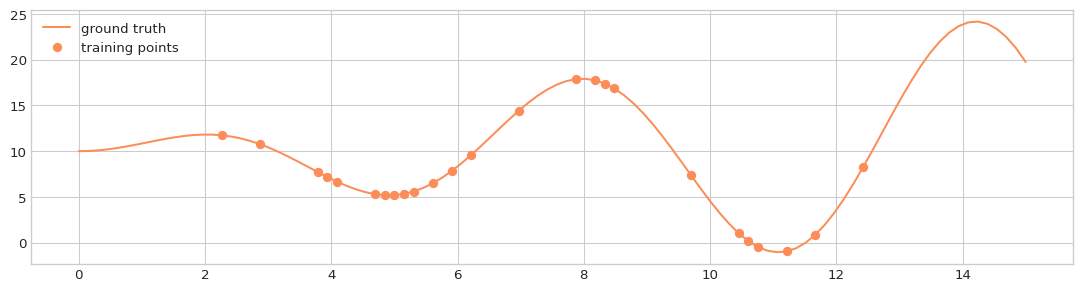

In [6]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.plot(X_support, y_support, label='ground truth', c='#fc8d59')
    ax.plot(X_train, y_train, 'o', label='training points', c='#fc8d59')
    ax.legend(loc='upper left')

**Cubic spline without extrapolation**:

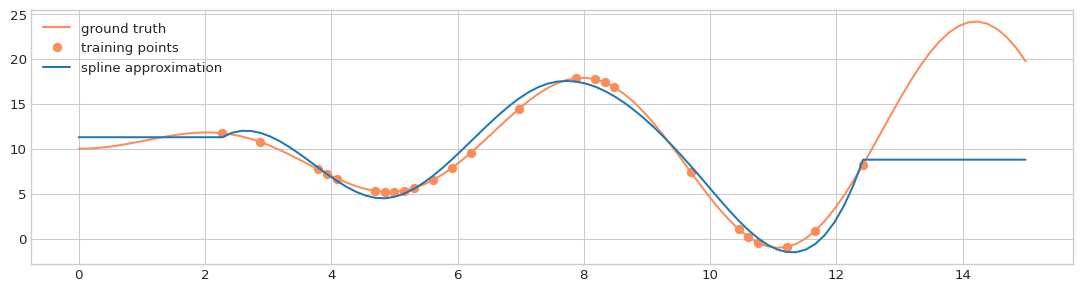

In [7]:
enc = SplineEncoder(feature='x', n_knots=5, degree=3, strategy='uniform', 
                        extrapolation='constant', include_bias=True,) 

model = make_pipeline(enc, LinearRegression(fit_intercept=False))
model.fit(X_train, y_train)
pred = model.predict(X_support)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.plot(X_support, y_support, label='ground truth', c='#fc8d59')
    ax.plot(X_train, y_train, 'o', label='training points', c='#fc8d59')
    ax.plot(X_support, pred, label='spline approximation')
    ax.legend(loc='upper left')

**With linear extrapolation**:

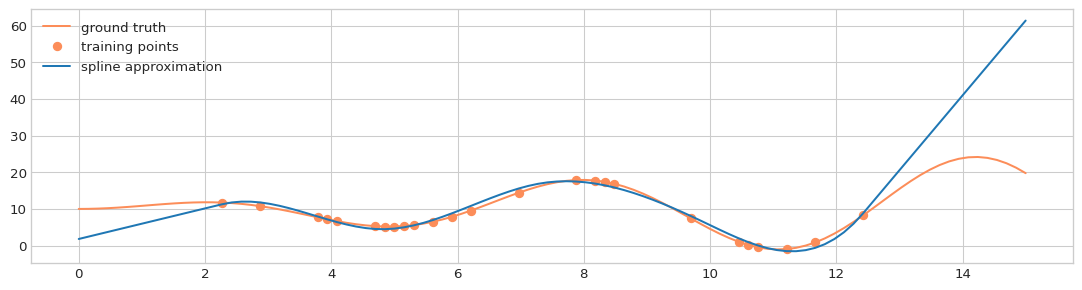

In [8]:
enc = SplineEncoder(feature='x', n_knots=5, degree=3, strategy='uniform', 
                        extrapolation='linear', include_bias=True,) 

model = make_pipeline(enc, LinearRegression(fit_intercept=False))
model.fit(X_train, y_train)
pred = model.predict(X_support)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(14, 3.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.plot(X_support, y_support, label='ground truth', c='#fc8d59')
    ax.plot(X_train, y_train, 'o', label='training points', c='#fc8d59')
    ax.plot(X_support, pred, label='spline approximation')
    ax.legend(loc='upper left')

## An application of the spline encoder

The [TOWT model](https://ieeexplore.ieee.org/document/5772947/) for predicting the energy consumption of a building estimates the temperature effect separately for hours of the week with high and with low energy consumption in order to distinguish between occupied and unoccupied periods. 

To this end, a flexible curve is fitted on the `consumption~temperature` relationship, and if more than the 65% of the data points that correspond to a specific hour-of-week are above the fitted curve, the corresponding hour is flagged as “Occupied”, otherwise it is flagged as “Unoccupied.” 

We can apply this approach using `feature_encoders` functionality.

### Load demo data

In [9]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]

In [10]:
dmatrix = SplineEncoder(feature='temperature', 
                        degree=1, 
                        strategy='uniform'
          ).fit_transform(data)
        
model = LinearRegression(fit_intercept=False).fit(dmatrix, data['consumption'])
pred = pd.DataFrame(
            data=model.predict(dmatrix), 
            index=data.index, 
            columns=['consumption']
       )

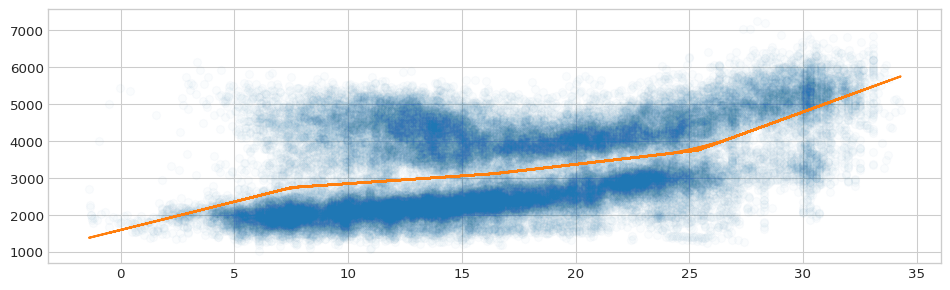

In [11]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.plot(data['temperature'], data['consumption'], 'o', alpha=0.02)
    ax.plot(data['temperature'], pred['consumption'])

In [12]:
resid = data[['consumption']] - pred[['consumption']]
mask = resid > 0
mask['hourofweek'] = 24 * mask.index.dayofweek + mask.index.hour
occupied = mask.groupby('hourofweek')['consumption'].mean() > 0.65

data['hourofweek'] = 24 * data.index.dayofweek + data.index.hour
data['occupied'] = data['hourofweek'].map(lambda x: occupied[x])

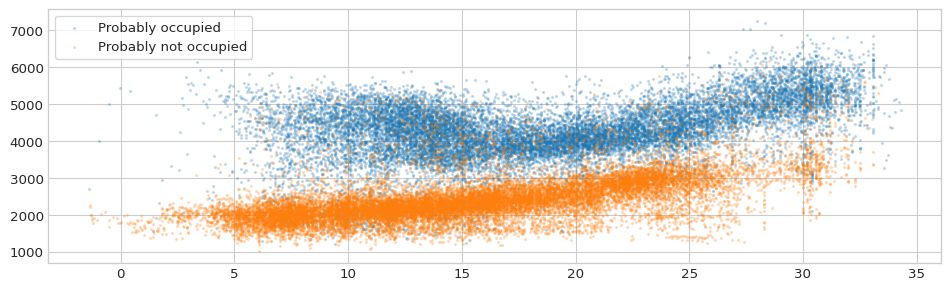

In [13]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.5), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    ax.scatter(data.loc[data['occupied'], 'temperature'], 
               data.loc[data['occupied'], 'consumption'], 
               s=2, alpha=0.2, label='Probably occupied')
    
    ax.scatter(data.loc[~data['occupied'], 'temperature'], 
               data.loc[~data['occupied'], 'consumption'], 
               s=2, alpha=0.2, label='Probably not occupied')
    
    ax.legend(fancybox=True, frameon=True, loc='upper left')

-----------------